# Recession Forecaster

The United States as of November, 2019 has experienced the longest expansion cycle, yet the media is buzzing with talks of an impending recession next year. Recessions happen around every 8 to 10 years, so the question is not if, but when and how much. 

The first part is to predict impact on GDP using regression, because NBER defines a recession as ["a significant decline in economic activity"](https://www.nber.org/cycles.html), not 2 consecutive quarters of decline in real GDP. The second part is to return a probabilistic model based on classification, similar to the [Bloomberg Recession Tracker](https://www.bloomberg.com/graphics/us-economic-recession-tracker/).

## Part 1- Vector Autoregression

### Feature Selection

While there are methods to systematically select variables, this is outside the scope of this analysis. Instead, selection will be based on domain knowledge. The following factors are considered when selecting input variables:
* having sufficient long term data, as recessions are rare occurrences;
* having forward predictive power, which means the inflection point should occur before or simultaneously as GDP;
* represent various aspects or mechanisms of the economy, such as a risk free benchmark;
* avoid composite indices to avoid double counting, as composite indices may incorporate  the selected features.

This selection is not final, as the model may dictate the addition or removal of variables.

For the decision variable:
* [**Real Gross Domestic Product**](https://fred.stlouisfed.org/series/GDPC1)- Inflation adjusted value of goods and services produced in a year.

For equities, the following variables are considered:
* [S&P 500](https://finance.yahoo.com/quote/%5EGSPC?p=^GSPC)- Weighted stock index of 500 companies listed on US exchanges with the largest market cap.
* [**S&P 500 Cyclically Adjusted PE Ratio**](https://www.quandl.com/data/MULTPL/SHILLER_PE_RATIO_MONTH-Shiller-PE-Ratio-by-Month) [(info)](https://www.investopedia.com/terms/c/cape-ratio.asp)- Normalizes PE ratio fluctuations over 10 year inflation-adjusted earnings. This indicator is used to gauge whether the equities market is over or under-valued.
* [**Nonfinancial Corporate Debt as Percentage of Equity**](https://fred.stlouisfed.org/series/NCBCMDPMVCE)- Contains companies outside of the S&P 500. Constructed using balance sheet valuations.

For bonds, the following variables are considered: 
* [10 Year Constant Maturity Minus 3 Month Treasuries Yield Spread](https://fred.stlouisfed.org/series/T10Y3M)- Financial institutions borrow at low rates short term, to lend at high rates long term. Long term treasury yield tends to be stable, but short term yields are more volatile, and subject to [FED interventions](https://fredblog.stlouisfed.org/2017/02/lets-do-the-twist/). This dataset only goes back to 1982, which is too little.
* [**10 Year Constant Maturity Minus 3 Month Treasuries Secondary Market Yield Spread**](https://fred.stlouisfed.org/series/TB3MS)- Makes up for the lack of data in the primary market. Primary and secondary market spreads are very close today, due to increased efficiency from electronic trading. Historically, the spread has been higher.
* [10 Year Treasuries Constant Maturity Rate](https://fred.stlouisfed.org/series/DGS10)- Long term treasuries usually reflect investor sentiment regarding long term economic growth. However, this metric alone does not provide evidence of short term liquidity.
* 3 Months Outstanding Repo [(info)](http://law.emory.edu/ecgar/content/volume-5/issue-2/essays/repo-recession-financial-regulation.html)- Before the Great Recession, investment banks used short term repo to inject liquidity to stay afloat. Uptick in short term repo may indicate credit crunch. FRED only has records of contracts with itself as a participant, leaving out the majority of transactions. Data on market transactions were difficult to find.

For inflation, the following indicators are considered:
* [**Consumer Price Index for Urban Consumers**](https://fred.stlouisfed.org/series/CPIAUCSL) [(info)](https://www.bls.gov/opub/btn/volume-3/why-does-bls-provide-both-the-cpi-w-and-cpi-u.htm)- Price inflation covering 88% of Americans, calculated from expenditures. Uses a survey to calculate the basket of goods and services; this basket is updated every 2 years.
* [Chained Consumer Price Index for Urban Consumers](https://fred.stlouisfed.org/series/SUUR0000SA0) [(info)](https://www.brookings.edu/blog/up-front/2017/12/07/the-hutchins-center-explains-the-chained-cpi/)- Basket is updated every 2 years, but the weight of the items changes every month to factor in consumer substitution purchases. Lacking long term data.

For employment, the following indicators are considered:
* [Labor Participation Rate](https://fred.stlouisfed.org/series/CIVPART)- Percent of population over 16 actively seeking or engaged in employment. Strongly driven by demographic trends, such as women participation in the workforce, or retirement of Baby Boomers.
* [**Total Nonfarm Payroll**](https://fred.stlouisfed.org/series/PAYEMS)- Size of the labor force, accounting for 80% of workers who contribute to GDP, excluding proprietors, unpaid volunteers, or farm workers.
* [Wage Growth](https://fred.stlouisfed.org/series/CES0500000003)- When labor demand outstrips supply, wages increase, and vise versa. Lack of long term data.

Lastly, the following indicators are not placed in any categories above, but are included because of their predictive power.
* [**Real Private Gross Investment**](https://fred.stlouisfed.org/series/GPDIC1)- Investment represents expenditure on capital goods and residential properties. Provides an indicator for future productivity and GDP growth. Also a strong sign of economic recovery.

The following indicators were considered, but ultimately dismissed.
* [Purchasing Managers' Index](https://www.instituteforsupplymanagement.org/ismreport/mfgrob.cfm?SSO=1)- A survey of supply chain professionals in 19 primary industries. Locked behind paywall.
* [Consumer Confidence Index](https://www.conference-board.org/data/consumerconfidence.cfm)- A survey of consumer purchases and sentiments. Locked behind paywall.
* [VIX Volatility Index](https://fred.stlouisfed.org/series/VIXCLS)- Describes the volatility, but not the direction, of stocks.
* [Effective Federal Funds Rate](https://fred.stlouisfed.org/series/FEDFUNDS)- This indicator is unfiltered by market forces as the FED has the direct control of this rate. Secondly, FED has pursued different doctrines throughout history, it was fighting inflation in the 70s, supporting deregulation in the 80s, inflation targeting in the 90s & 2000s, then quantitative easing in the 2010s.
* [Personal Savings Rate](https://fred.stlouisfed.org/series/PSAVERT)- Strongly driven by demographic trends, such as women entering workforce, or retirement of Baby Boomers.
* [Incremental Capital Outputs Ratio](https://www.investopedia.com/terms/i/icor.asp)- Calculates how much additional capital investment is needed to create growth. Hard to find on the web.

### Data Preparation

First, import the necessary packages.

In [1]:
import fredapi
import requests
import json
import numpy as np
import pandas as pd
import scipy
from functools import reduce
from math import ceil
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import acf
from copy import deepcopy
from dateutil.relativedelta import relativedelta

#### Import FRED Data

To import FRED data, an API key is needed. FRED API key can be requested [here](https://research.stlouisfed.org/docs/api/fred/). Looking at the data returned, the following observations can be made:
* data are in "Series" format, they to be converted to "DataFrame" format;
* the column names are the same, making it difficult to manipulate, they will be renamed;
* some data are provided on a monthly frequency, while others are quarterly.

In [2]:
f = fredapi.Fred(api_key='8b91217446b6307d20cb5e4fcfba70eb') # remove API when done

def generate_fred_dataframe(name, series_url):
    return f.get_series(series_url).to_frame().reset_index().rename(columns={'index':'date', 0:name})

# monthly data.
tbill_3m = generate_fred_dataframe('tbill_3m', 'TB3MS')
tbill_10y = generate_fred_dataframe('tbill_10y', 'GS10')
cpiu = generate_fred_dataframe('cpiu', 'CPIAUCSL')
payroll = generate_fred_dataframe('payroll', 'PAYEMS')
# quarterly data
dtoe = generate_fred_dataframe('dtoe', 'NCBCMDPMVCE')
pinvest = generate_fred_dataframe('pinvest', 'GPDIC1')
gdp = generate_fred_dataframe('gdp', 'GDPC1')

#### Import Quandl Data

To import Quandl data, API key can be requested [here](https://docs.quandl.com/docs/getting-started). Looking at the data returned, the following observations can be made:
1. data is listed from newest to oldest, this order will be reversed;
2. the columns must be renamed;
4. "date" column is a a string, it needs to be converted to "datetime64" format, for compatibility with other data.

In [3]:
quandl_api_key = '8ufKe7Y2JMsYPU3CGN7m'

def generate_quandl_dataframe(name, series_url):
    res = pd.DataFrame.from_dict(requests.get(series_url.format(quandl_api_key)).json()['dataset']['data'])
    res = res[::-1].rename(columns={0:'date', 1:name})
    res['date'] = res['date'].astype('datetime64')
    return res

sp500 = generate_quandl_dataframe('sp500_cape', 'https://www.quandl.com/api/v3/datasets/MULTPL/SHILLER_PE_RATIO_MONTH.json?api_key={}')
sp500_cape = generate_quandl_dataframe('sp500_cape', 'https://www.quandl.com/api/v3/datasets/MULTPL/SHILLER_PE_RATIO_MONTH.json?api_key={}')

#### Converting Quarterly to Monthly Data

To convert quarterly to monthly data, the "resample" method is called.

In [4]:
dtoe = dtoe.set_index('date').resample('MS').asfreq()
pinvest = pinvest.set_index('date').resample('MS').asfreq()
gdp = gdp.set_index('date').resample('MS').asfreq()

#### Interpolate Null Values

Resampling creates null value gaps in the dataset. To fill in the null values, [cubic spline interpolation](https://columbiaeconomics.com/2010/01/20/how-economists-convert-quarterly-data-into-monthly-cubic-spline-interpolation/), a technique commonly used by economists, to fill in the missing values. Cubic spline has better smoothing over quadratic interpolation.

Interpolation converts data to "Series" format, it needs to be converted back to "DataFrame" type.

In [5]:
gdp['gdp'] = gdp['gdp'].interpolate(method='spline', order=3)
dtoe['dtoe'] = dtoe['dtoe'].interpolate(method='spline', order=3)
pinvest['pinvest'] = pinvest['pinvest'].interpolate(method='spline', order=3)

pinvest.head(2)

,pinvest
date,
1947-01-01,218.091000
1947-02-01,250.643025


#### Merge Datasets

Note that variables have different start dates, merging the datasets will automatically trim the start dates to April 1953, and the end date to April 2018, which should exclude any null values.

In [6]:
print(tbill_3m.head(1))
print(cpiu.head(1))

        date  tbill_3m
0 1934-01-01      0.72
        date   cpiu
0 1947-01-01  21.48


In [7]:
data = [tbill_3m, tbill_10y, cpiu, payroll, dtoe, pinvest, sp500_cape, gdp]
data = reduce(lambda left,right: pd.merge(left,right,on='date'), data)
data = data.set_index('date')

data.isnull().sum()

tbill_3m      0
tbill_10y     0
cpiu          0
payroll       0
dtoe          0
pinvest       0
sp500_cape    0
gdp           0
dtype: int64

#### Deriving Treasury Spread

FRED has a graph, but not a series on [10 year - 3 month spread](https://fred.stlouisfed.org/graph/?g=oGg), making it impossible to import it using the standard method. To derive the desirable dataset, 10 year and 3 month treasuries are differenced against each other.

In [8]:
data['tbill_10y'] = data['tbill_10y'] - data['tbill_3m']
data = data.drop('tbill_3m', axis=1).rename(columns={'tbill_10y':'tbill'})

### Preliminary Analysis

There are 793 months of data in the dataset. 

*CPIU, PINVEST*, and *GDP* are right skewed by comparing the mean to median (50%).

In [9]:
data.describe()

,tbill,cpiu,payroll,dtoe,pinvest,sp500_cape,gdp
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000
mean,1.477011,116.719218,98634.532156,53.327181,1389.294558,19.850038,9204.318404
std,1.163736,75.631481,31731.058247,19.541533,925.368623,7.651430,4910.710657
min,-2.650000,26.690000,48826.000000,27.378639,258.824569,6.640000,2648.982402
25%,0.620000,37.300000,70792.000000,37.850009,585.092622,14.610000,4938.993964
50%,1.450000,109.500000,99121.000000,45.765423,1143.396708,19.620000,8185.303000
75%,2.410000,181.200000,130666.000000,67.745365,2222.691300,24.350000,13559.032000
max,4.420000,254.958000,151012.000000,102.570130,3481.088000,44.190000,19021.860000


#### Data Visualization

In [10]:
def choose_subplot_dimensions(k):
    '''sets nrow and ncol parameter in plots based on number of rows'''
    if k <2:
        return k, 1
    elif k <= 4:
        return ceil(k/2), 2
    else:
        return ceil(k/3), 3

def generate_subplots(data_input, row_wise=True):
    k = int(len(data_input.columns))
    nrow, ncol = choose_subplot_dimensions(k)
    fig, axes = plt.subplots(nrow, ncol, dpi=120, figsize=(10, 4), sharey=False)

    if not isinstance(axes, np.ndarray):
        return fig, [axes]
    else:
        axes = axes.flatten(order=('C' if row_wise else 'F'))
        for idx, ax in enumerate(axes[k:]):
            fig.delaxes(ax)
            idx_to_turn_on_ticks = idx + k - ncol if row_wise else idx + k - 1

            for tk in axes[idx_to_turn_on_ticks].get_xticklabels():
                tk.set_visible(True)

        axes = axes[:k]
        return fig, axes
    
def generate_plots(data_input, row_wise=True):
    fig, axes = generate_subplots(data_input, row_wise=True)
    for col, ax in enumerate(axes.flatten()):
        ax.plot(data_input[data_input.columns[col]], color='red', linewidth=1)
        ax.set_title(data_input.columns[col])
        ax.tick_params(which='major', labelsize=8)
        ax.tick_params(which='minor', labelsize=6)
    
    plt.tight_layout()

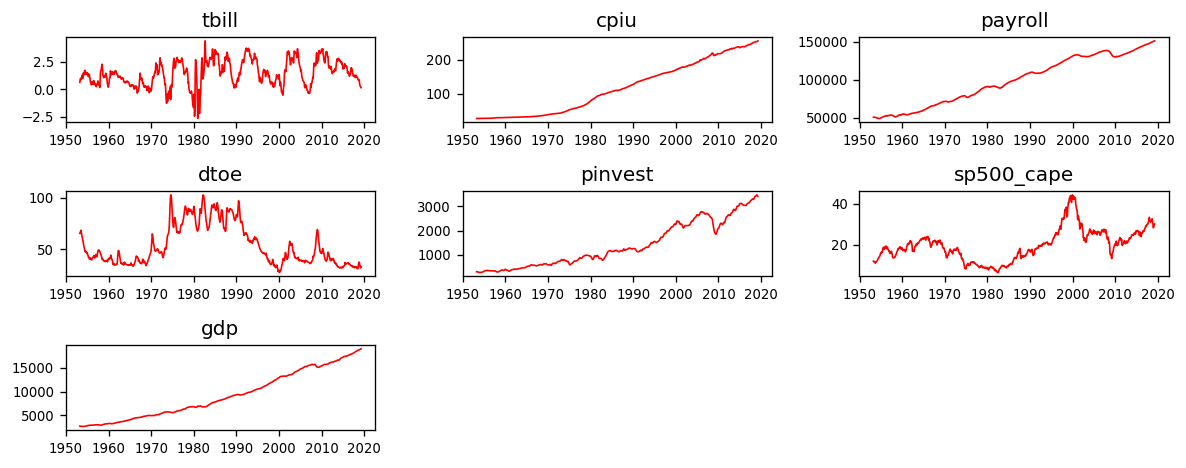

In [11]:
generate_plots(data, row_wise=True)

#### Check for Correlation

In [12]:
def generate_corr_heatmap(data_input):
    plt.figure(figsize = (10,5))
    ax = sb.heatmap(data_input.corr(), 
                    xticklabels=data_input.columns.values, 
                    yticklabels=data_input.columns.values, 
                    annot=True, annot_kws={'size':12})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

*CPIU, PAYROLL, PINVEST*, and *GDP* are highly correlated. High correlation in input variables may cause multicollinearity. Multicollinearity reduces the statistical significance of the variables, making it difficult to pinpoint which variable is responsible for changes in *GDP*.

Before deciding if any variables should be removed, it is best to continue the exploration to gain a better picture.

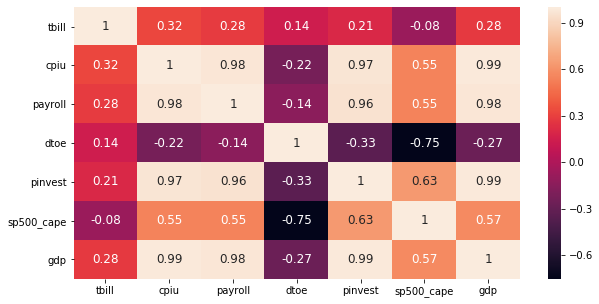

In [13]:
generate_corr_heatmap(data)

#### Model Selection

For dealing with multiple variables, a vector autoregression (VAR) model can handle this problem.

VAR is a stochastic (random) process that captures linear relationship between all variables. VAR assumes all variables are dependent on each other, and that change in 1 variable will induce change in another. This trait is called Granger causality, and will be verified in the following analysis.

#### Test for Autocorrelation

Autocorrelation compares the lag value with all values before it, it explain how well the past and present values are related, or how well past values predict present value. Partial autocorrelation compares the lag value of the residuals, discounting the correlated portion.

*GDP* is highly autocorrelated. While this feature allows a generalization of *GDP* trend (2% year-over-year growth), it is undesirable as it may overwhelm influence from other variables.

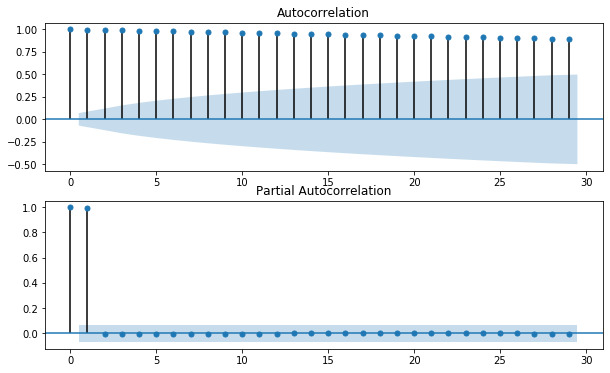

In [14]:
fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0] = plot_acf(data.gdp, ax=ax[0])
ax[1] = plot_pacf(data.gdp, ax=ax[1])

#### Test for Stationarity

For VAR model to work correctly, all data must be stationary, meaning the mean and variance generally stays the same overtime. Many models, VAR included, do not deal with non-stationary data very well..

In this case, if the p-value is less than 0.05, then the series is classified as stationary.

In [15]:
class StationarityTests:
    def __init__(self, alpha=.05):
        self.SignificanceLevel = alpha
        
    def ADF_Stationarity_Test(self, timeseries):
        adfTest = adfuller(timeseries, autolag='AIC')
        self.pValue = adfTest[1]
        
        if (self.pValue < self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags','# Observations'])
        dfResults['Critical Value 5%'] = adfTest[4]['5%']

        return dfResults
        

sTest = StationarityTests()

In [16]:
for var in data:
    print(sTest.ADF_Stationarity_Test(data[var]))
    print('Is {} series stationary? {}'.format(var, sTest.isStationary))
    print('\n')

ADF Test Statistic     -5.092447
P-Value                 0.000015
# Lags                 16.000000
# Observations        776.000000
Critical Value 5%      -2.865272
dtype: float64
Is tbill series stationary? True


ADF Test Statistic      1.765773
P-Value                 0.998279
# Lags                 15.000000
# Observations        777.000000
Critical Value 5%      -2.865267
dtype: float64
Is cpiu series stationary? False


ADF Test Statistic     -0.174749
P-Value                 0.941465
# Lags                  4.000000
# Observations        788.000000
Critical Value 5%      -2.865215
dtype: float64
Is payroll series stationary? False


ADF Test Statistic     -1.102667
P-Value                 0.714007
# Lags                 21.000000
# Observations        771.000000
Critical Value 5%      -2.865296
dtype: float64
Is dtoe series stationary? False


ADF Test Statistic      0.376772
P-Value                 0.980605
# Lags                 17.000000
# Observations        775.000000
Criti

#### Data Transformation

To make our data stationary, one method is to take the first difference of the cube root of data. Cube rooting has the benefit of reducing right skewness, in an exponentially trending dataset, this makes the distribution more normal. **Normality contributes to stationarity, but a stationary dataset does not need to be normal.** However, cube rooting itself does not make the dataset stationary, as the trend characteristic remains, which is why differencing is needed.

Another appropriate transformation method is a simple first difference. First difference method is one of the most common methods, and will work for majority of cases.

$${y} = {x_{t}}^{1/3} - {x_{t-1}}^{1/3}$$

In [17]:
# data_trans = data.diff(1).dropna()
data_cube_root = data ** (1/3) 
data_trans = data_cube_root.diff(1).dropna()

#### Normality Test

Through the naked eye, it may be difficult to discern which transformation is more normal. For example, the cube root transformation is a two peak distribution, while at the same time being less skewed. This is why statistical methods should be employed. In this case, both Shapiro-Wilk and D'Agostino's Chi-Sqaured tests will be used.

There is one caveat with these normality tests, that the bigger the sample size, the more sensitive the test becomes to to variance from normal, and more likely the distribution to have small p-value, increasing the likelihood of false negative.

In [18]:
def generate_histogram(data_input, bins, plot_name, color='blue'):
    plt.figure(figsize=(20,3))
    plt.hist(data_input, bins, color=color)
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.title(str(plot_name))
    plt.show()

Simple Difference Transformation mean: 20.58478661616162
Simple Difference Transformation std.dev: 24.252443181873005
Cube Root Difference Transformation mean: 0.01746512094870466
Cube Root Difference Transformation std.dev: 0.017943607483992947


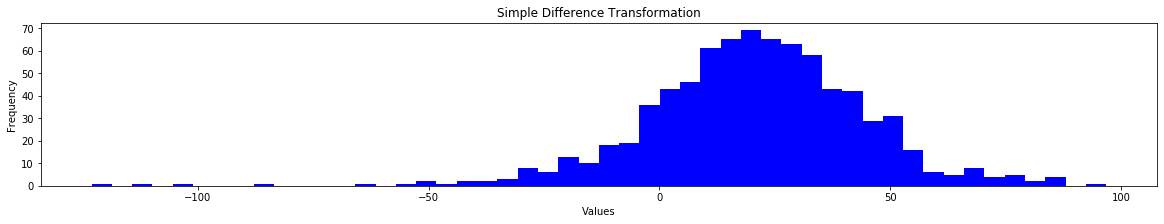

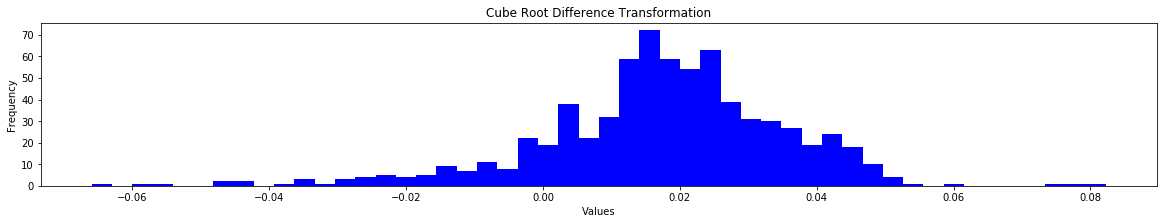

In [19]:
hist_1 = data['gdp'].diff().dropna()
hist_2 = data_trans['gdp']

print('Simple Difference Transformation mean:', sum(hist_1) / len(hist_1))
print('Simple Difference Transformation std.dev:', np.std(hist_1))
print('Cube Root Difference Transformation mean:', sum(hist_2) / len(hist_2))
print('Cube Root Difference Transformation std.dev:', np.std(hist_2))

generate_histogram(hist_1, bins=50, plot_name='Simple Difference Transformation')
generate_histogram(hist_2, bins=50, plot_name='Cube Root Difference Transformation')

Shapiro-Wilk test evaluates how likely a data sample was drawn from a normally distributed population. While Shapiro-Wilk test underperforms when dealing with datasets with repeated data values, or datasets with sample sizes larger than 5K, neither of those conditions apply.

The larger the W statistics, the larger the p-value, and the more likely the dataset comes from a population with a normal distribution. The distribution cannot reject the null hypothesis when p-value is greater than 0.05. In this case, the cube root transformation is more normal than the simple difference.

In [20]:
print('Simple Difference Transformation Value Frequency')
print(hist_1.value_counts(sort=True, ascending=False).head(3))
print('\n')

print('Cube Root Difference Transformation Value Frequency')
print(hist_2.value_counts(sort=True, ascending=False).head(3))

Simple Difference Transformation Value Frequency
10.960858    1
50.166827    1
35.947793    1
Name: gdp, dtype: int64


Cube Root Difference Transformation Value Frequency
-0.002033    1
 0.035651    1
-0.059633    1
Name: gdp, dtype: int64


In [21]:
def shapiro_test(data_input):
    stat, p = scipy.stats.shapiro(data_input)
    print('W statistics = ', stat, 'p-value = ', p)

In [22]:
print('SW- Simple Difference Transformation:')
shapiro_test(hist_1)
print('\n')

print('SW- Cube Root Difference Transformation:')
shapiro_test(hist_2)

SW- Simple Difference Transformation:
W statistics =  0.9599864482879639 p-value =  6.956540649517146e-14


SW- Cube Root Difference Transformation:
W statistics =  0.9610707759857178 p-value =  7.682122624662335e-13


D'Agostino's Chi-Squared test computes the skewness and kurtosis. Skewness is the proportion of values in one tail vs. the other. Kurtosis is the proportion of data in the two tails, in this case, the [Ronald Fisher definition](https://www.geeksforgeeks.org/scipy-stats-kurtosis-function-python/) is used. The model then calculates how far each of these values differs from the value expected from a normal distribution, and computes a single p-value from the sum of these discrepancies.

The smaller the squared sum of skewness and kurtosis, the bigger the p-value, and the more likely the dataset comes from a population with a normal distribution. The distribution cannot reject the null hypothesis when p-value is greater than 0.05. In this case, the cube root transformation is more normal than the simple difference.

In [23]:
def dagostino_k2_test(data_input):
    s, p_skew = scipy.stats.skewtest(data_input)
    k, p_kurtosis = scipy.stats.kurtosistest(data_input)
    stat, p = scipy.stats.normaltest(data_input)
    print('skewness:', s)
    print('kurtosis:', k)
    print('s^2 + k^2 =', stat, 'p-value =', p)

In [24]:
print('DK2- First Difference Transformation:')
dagostino_k2_test(hist_1)
print('\n')

print('DK2- Cube Root Difference Transformation:')
dagostino_k2_test(hist_2)

DK2- First Difference Transformation:
skewness: -7.924189440505621
kurtosis: 8.648546598816514
s^2 + k^2 = 137.59013656092148 p-value = 1.326421227824708e-30


DK2- Cube Root Difference Transformation:
skewness: -7.237131332832766
kurtosis: 6.389433648295432
s^2 + k^2 = 93.20093227463965 p-value = 5.776632009634279e-21


#### Splitting Data Into Trainng and Testing Sets

For training and validation, the test period is set to 12 months prior to the latest entry.

In [25]:
test_periods = 12
train, test = data[0:-test_periods], data[-test_periods:]
train_trans = data_trans[0:-test_periods]
train_trans.tail()

,tbill,cpiu,payroll,dtoe,pinvest,sp500_cape,gdp
date,,,,,,,
2017-12-01,-0.012513,0.004810,0.020775,-0.001697,0.029596,0.026294,0.016929
2018-01-01,0.027743,0.008292,0.020401,-0.006848,0.013713,0.039771,0.019348
2018-02-01,0.034859,0.004083,0.039326,-0.004673,-0.012089,-0.041422,0.023938
2018-03-01,-0.043943,0.001085,0.021664,-0.009954,-0.015367,-0.007618,0.024367
2018-04-01,-0.009245,0.003850,0.023311,0.013240,0.004534,-0.028139,0.027834


#### Data After Transformation

Checking for autocorrelation, much autocorrelation have been eliminated. **This means the prediction of *GDP* will be influenced more by other variables, and less by its past.**

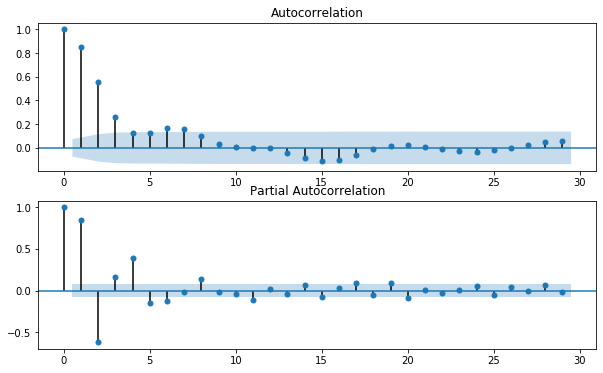

In [26]:
fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0] = plot_acf(train_trans.gdp, ax=ax[0])
ax[1] = plot_pacf(train_trans.gdp, ax=ax[1])

The dataset is also stationary.

In [27]:
for var in train:
    sTest.ADF_Stationarity_Test(train_trans[var])
    print("Is {} series stationary? {}".format(var, sTest.isStationary))

Is tbill series stationary? True
Is cpiu series stationary? True
Is payroll series stationary? True
Is dtoe series stationary? True
Is pinvest series stationary? True
Is sp500_cape series stationary? True
Is gdp series stationary? True


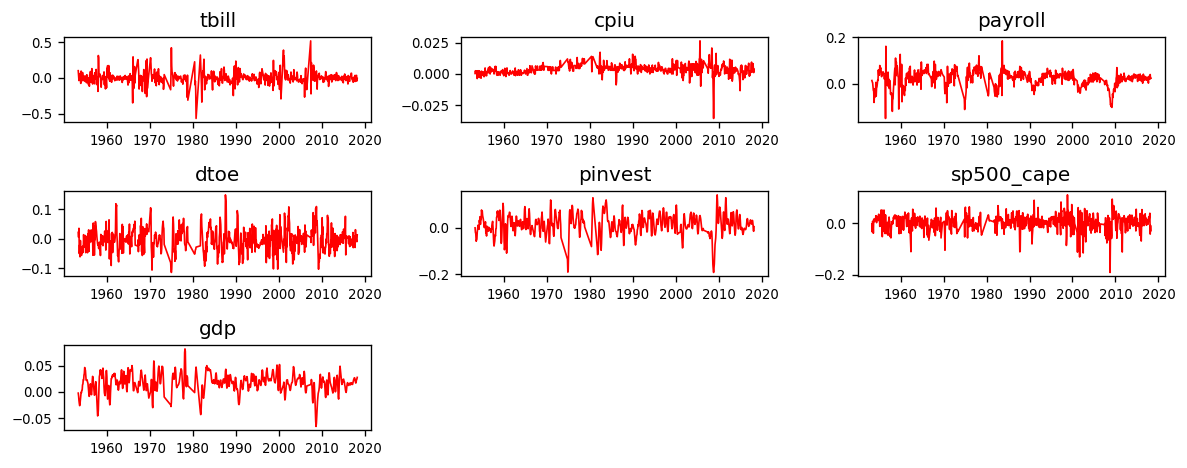

In [28]:
generate_plots(train_trans, row_wise=True)

Much of the correlation between series has been nullified after transformation, reducing multicollinearity risks.

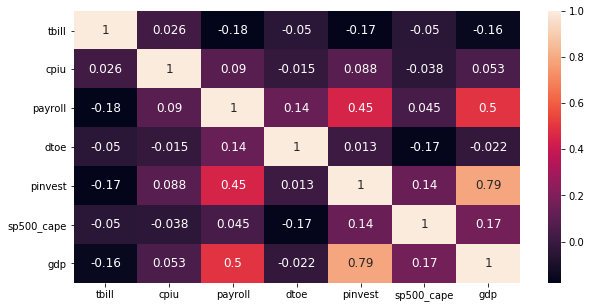

In [29]:
generate_corr_heatmap(train_trans)

#### Lag Order Selection

VAR uses [4 metrics](https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other) for [lag order selection](https://sccn.ucsd.edu/wiki/Chapter_3.5._Model_order_selection). The lag orders with the least error value is desired: 

* Aikaike Information Criterion (AIC)- AIC is more liberal for large , complex models, and is best used for forecasting. AIC has the tendency to choose large lag order. When lag order is too large, and may cause overfitting.
* Baysian Information Criteron (BIC)- BIC assumes reality is a candidate in the model, meaning a definitive amount of variables have definitive predictive, when a definitive lag order is used. BIC has the tendency to choose small lag order, and may cause underfitting.
* Final Prediction Error (FPE)- FPE is similar to AIC, but may outperform (lower mean squared error) than AIC in small sample sizes.
* Hannan-Quinn Information Criterion (HQIC)- Similar to BIC, but penalizes large variable selection less.

For this mode, FPE is the most appropriate choice, as BIC and HQIC make the false assumption that the true model is among the candidates (if such model exists at all in economics), and AIC works better with large sample size.

In [30]:
print('AIC:', VAR(train_trans).fit(maxlags=24, ic='aic').k_ar)
print('BIC:', VAR(train_trans).fit(maxlags=24, ic='bic').k_ar)
print('FPE:', VAR(train_trans).fit(maxlags=24, ic='fpe').k_ar)
print('HQIC:', VAR(train_trans).fit(maxlags=24, ic='hqic').k_ar)

C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


AIC: 9
BIC: 4
FPE: 9
HQIC: 4


C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### Granger Causality Test

Granger causality test assumes there is no relationship between the lag value of x(column) and present value of y(row), if resultant p-value is greater than 0.05. If there is no causal relationship, then it means a variable has no impact on another, and it does not matter whether it is included or not.

In [31]:
lag_order = VAR(train_trans).fit(maxlags=24, ic='fpe').k_ar

def grangerstest(data_input, variables, test='ssr_chi2test'):
    res = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in data_input.columns:
        for r in res.index:
            granger_res = grangercausalitytests(data_input[[r, c]], maxlag=lag_order, verbose=False)
            p_values = [round(granger_res[i+1][0][test][1],4) for i in range(lag_order)]

            res.loc[r, c] = min(p_values)
    res.columns = [var + '_x' for var in variables]
    res.index = [var + '_y' for var in variables]
    return res

def generate_pval_map(data_input, max_lag):
    gct = grangerstest(data_input, variables=data_input.columns)
    cmap1 = ListedColormap(['r'])

    plt.figure(figsize = (10,5))
    ax = sb.heatmap(gct, 
            xticklabels=gct.columns.values, 
            yticklabels=gct.index.values, 
                mask=gct < 0.05, cmap=cmap1, cbar=False, 
                annot=True, annot_kws={'size':12})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    plt.show()

C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In the heatmap below, pairs with p-values larger than 0.05 are deemed to have no causal relationship. This relationship can be one way, as seen in *tbill* and *SP500_CAPE* or two ways, exemplified by *TBILL* and *CPIU*. Including variable pairs with no causal relationship could mislead the model.

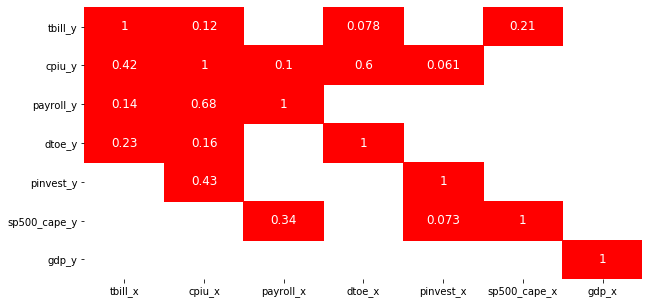

In [32]:
generate_pval_map(train_trans, max_lag=lag_order)

#### Cointegration Test

Cointegration test is another way to test whether a variable pair has significant relationship. Cointegration relation exists when lagging one variable against another (order of integration or lag order), the distance between variables is stationary through time. If two variables are cointegrated, Granger causality must exist (even if a weak one, or one way causality).

Johansen test tests two variables together, then tests whether this combined pair has lower order of integration than a single variable on its own. If so, then the variables are cointegrated.

To conduct Johansen test, 3 variables are passed into the function:
1. data to be tested,
2. 1 for stochastic nature of the data, and
3. number of lagged periods.

While there are many literature on whether the economy is [deterministic or stochastic](https://fraser.stlouisfed.org/files/docs/historical/frbsf/frbsf_let/frbsf_let_19930212.pdf), with proponents of a deterministic model arguing GDP hinders on the long term supply factors, such as capital, labor, and technology, and that growth rate should stay the same overtime; while proponents of a stochastic model would point to "permanent" changes to the growth rate, positive or negative, such as sudden sharp slope increase in supply factors since the industrial revolution. One criticism of the deterministic model points out that if the economy and human development were deterministic, people would still be living in conditions similar to the 17th century.

Testing with lag order of 9, cointegration test failed. This is due to a large number of non-causal variables. There are two ways to deal with this:
1. reduce the lag order, or
2. reduce the number of variables.

**Reducing the lag order reduces the amount of data samples fed into the model, which risks "judging a book by its cover", and making a false representation of what a variable is actually trying to tell us. Reducing the amount of variables, especially those with no or weak Granger causality, is the better method.**

In [33]:
def cointegration_test(data_input, det_order, lag_order, significance=0.05):
    out = coint_johansen(data_input, det_order, lag_order)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-significance)]]

    def adjust(val, length=6): return str(val).ljust(length)
    print('Name   ::  Test Stat  >  C(95%)    => Signif  \n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), '> ', adjust(cvt, 8), ' => ', trace > cvt)

cointegration_test(train_trans, det_order=-1, lag_order=lag_order)

Name   ::  Test Stat  >  C(95%)    => Signif  
 ----------------------------------------
tbill  ::  424.86    >  111.7797  =>  True
cpiu   ::  303.53    >  83.9383   =>  True
payroll ::  219.67    >  60.0627   =>  True
dtoe   ::  145.65    >  40.1749   =>  True
pinvest ::  88.72     >  24.2761   =>  True
sp500_cape ::  42.36     >  12.3212   =>  True
gdp    ::  2.35      >  4.1296    =>  False


Below is a modified function to find the highest lag order that satisfies the cointegration test, if none are found, it will return the lag order that minimizes FPE.

In [34]:
def cointegration_test_lag_order_detection(data_input, det_order, lag_order, significance=0.05):
    out = coint_johansen(data, det_order, lag_order)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-significance)]]
    return traces > cvts

def set_coint_lag_order(data_input, det_order, max_lag, significance=0.05):
    for i in reversed(range(0, max_lag)):
        if all(cointegration_test_lag_order_detection(data_input, det_order=-1, lag_order=i)) == True:
            return i
        else:
            '''if all return false, use FPE values from model selection'''
            model = VAR(data_input)
            model_fitted = model.fit(maxlags=24, ic='fpe')
            return model_fitted.k_ar

#### Dimensionality Reduction

When removing variables, the following factors are considered:
1. ensure unique features are retained, and 
2. ensure granger causality exists (at least one way).

Satisfying the first condition is more difficult, as the variables were already selected to "represent various aspects or mechanisms of the economy". Which is why the second condition will be satisfied first. The variable (x) most problematic for cointegration will be removed, then repeat the process for subsequent variables. The first variable to be removed is *CPIU*, the second variable is *TBILL*. 

*PINVEST* and *PAYROLL* also have p-values above 0.05, but the p-values are not as drastic as those seen in *cpiu* and *TBILL*. It is decided that *PINVEST* and *PAYROLL* will be kept to better satisfy the first condition.

In [35]:
gct = grangerstest(train_trans, train_trans.columns)
print('Sum of p-value greater than 0.05:')
print(gct[gct >= 0.05].sum().sort_values(ascending=False))

Sum of p-value greater than 0.05:
cpiu_x          2.3920
tbill_x         1.7903
dtoe_x          1.6771
payroll_x       1.4429
sp500_cape_x    1.2067
pinvest_x       1.1337
gdp_x           1.0000
dtype: float64


In [36]:
train_trans = train_trans.drop(['cpiu'], axis=1)
gct = grangerstest(train_trans, train_trans.columns)
print('Sum of p-value greater than 0.05:')
print(gct[gct >= 0.05].sum().sort_values(ascending=False))

Sum of p-value greater than 0.05:
tbill_x         1.3711
payroll_x       1.3426
sp500_cape_x    1.2067
dtoe_x          1.0781
pinvest_x       1.0727
gdp_x           1.0000
dtype: float64


Combining everything the knowledge gleamed from data exploration, *CPIU* and *TBILL* will be removed. To ensure no accidental transformation has occurred, let us reconstruct the dataset. The optimal lag order after variable reduction is 18.

In [37]:
data = [tbill_3m, tbill_10y, cpiu, payroll, dtoe, pinvest, sp500_cape, gdp]
data = reduce(lambda left,right: pd.merge(left,right,on='date'), data)
data = data.set_index('date')

data['tbill_10y'] = data['tbill_10y'] - data['tbill_3m']
data = data.drop('tbill_3m', axis=1).rename(columns={'tbill_10y':'tbill'})

data = data.drop(['tbill', 'cpiu'], axis=1)
data_cube_root = data ** (1/3)
data_trans = data_cube_root.diff(1).dropna()

train, test = data[0:-test_periods], data[-test_periods:]
train_trans = data_trans[0:-test_periods]

lag_order = set_coint_lag_order(train_trans, det_order=-1, max_lag=36, significance=0.05)
print('lag order:', lag_order)

lag order: 18


C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Name   ::  Test Stat  >  C(95%)    => Signif  
 ----------------------------------------
payroll ::  169.22    >  60.0627   =>  True
dtoe   ::  108.94    >  40.1749   =>  True
pinvest ::  58.75     >  24.2761   =>  True
sp500_cape ::  28.63     >  12.3212   =>  True
gdp    ::  2.17      >  4.1296    =>  False
None


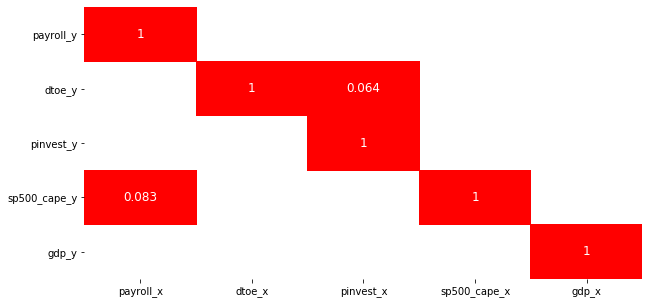

In [38]:
print(cointegration_test(train_trans, det_order=-1, lag_order=lag_order))

generate_pval_map(train_trans, max_lag=lag_order)

### VAR Model

Running the following functions returns the VAR model. 

In [39]:
train_model = VAR(train_trans)
train_model_fitted = train_model.fit(lag_order)
# train_model_fitted.summary()

C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


#### Check for Residual Correlation with Durbin Watson Test

If the transformation and lag order selection was conducted correctly, there should be little to no correlation between the residual errors. The existence of residual correlation implies unexplained pattern.

Result values can range between 0 to 4, with 0-2 indicating a positive correlation, and 2-4 indicating negative correlation. It is generally acceptable for values to be between 1.5 to 2.5.

In [40]:
for col, val in zip(train_trans.columns, durbin_watson(train_model_fitted.resid)):
    print((col), ':', round(val, 2))

payroll : 2.0
dtoe : 1.96
pinvest : 2.01
sp500_cape : 1.99
gdp : 2.0


#### Forecasting

VAR model only takes in data specified within the lag order (18 samples). A common misunderstanding is that information outside of the specified range is lost, but this is not the case. The model does assumes data outside of the lag order to be irrelevant, because all 793 samples were fed into the model to derive the lag order.

In [41]:
train_forecast_input = train_trans.values[-lag_order:]

train_forecast = pd.DataFrame(train_model_fitted.forecast(train_forecast_input, test_periods), 
                        index=data.index[-test_periods:], 
                        columns=data.columns)

#### Inverting Transformation

The transformation done to the dataset must be reversed, first by taking the cumulative sum of the first difference transformation, then add the baseline (the first value in the dataset, as the dataset does not start at 0), then add the last known training data.

In [42]:
train_trans_cumsum = train_trans.cumsum()
train_trans_cumsum.tail()

train_forecast_reverse = (train_forecast.cumsum() + train_trans_cumsum.iloc[-1, :] + data_cube_root.iloc[0, :]) ** 3

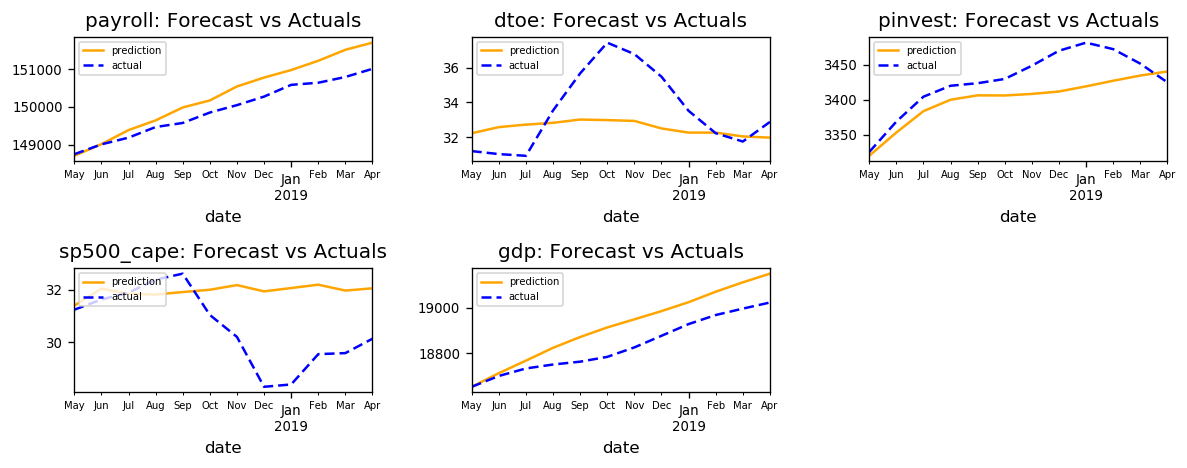

In [43]:
fig, axes = generate_subplots(train_forecast_reverse, row_wise=True)
for i, (col,ax) in enumerate(zip(train_forecast_reverse.columns, axes.flatten())):
    train_forecast_reverse[col].plot(color='orange', label='prediction', legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col].plot(color='blue', label='actual', legend=True, dashes=[4, 2], ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.tick_params(which='major', labelsize=8)
    ax.tick_params(which='minor', labelsize=6)
    ax.legend(loc='upper left', fontsize=6)

plt.tight_layout();

At first glance, the model may exhibit underfitting in *DTOE* and *SP500_CAPE*. To evaluate the model's accuracy, it is evaluated according to the following metrics:
* Mean Absolute Percentage Error (MAPE)- Accuracy expressed as a percentage, the lower the value, the greater the accuracy. However, MAPE is not a good metric datasets with small denominator, because as denominator approaches zero, the value of MAPE approaches infinity.
* Correlation (CORR)- Correlation between prediction and actual data. Low values may suggest underfitting, while high values may suggest overfitting.
* Mean Absolute Error (MAE)- Average of the absolute difference between actual vs.forecasted value, or the variance of the residuals. MAE is commonly used to compare between models.
* Root Mean Square Error (RMSE)- RMSE is best for measuring the variance of the frequency distribution of the residuals. RMSE also penalizes large errors, which is useful when large deviations from the expected value is undesirable.

Since there is only one model, MAE and RMSE does not provide any useful insight.

In [44]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
#     mae = np.mean(np.abs(forecast - actual))
#     rmse = np.mean((forecast - actual) ** 2) ** (1/2)
    corr = np.corrcoef(forecast, actual)[0,1]
#     return({'MAPE':mape, 'MAE': mae, 'RMSE':rmse, 'CORR':corr})
    return({'MAPE':mape, 'CORR': corr})

In [45]:
def print_forecast_accuracy(forecast, actual):
    for col in forecast:
        print('Forecast accuracy of {}'.format(col))
        metrics = forecast_accuracy(forecast[col].values, actual[col])
        for k, v in metrics.items():
            print(k, ': ', round(v,4))
        print('\n')

print_forecast_accuracy(forecast=train_forecast_reverse, actual=test)

Forecast accuracy of payroll
MAPE :  0.0025
CORR :  0.9959


Forecast accuracy of dtoe
MAPE :  0.0516
CORR :  0.6123


Forecast accuracy of pinvest
MAPE :  0.0082
CORR :  0.8769


Forecast accuracy of sp500_cape
MAPE :  0.0541
CORR :  -0.3939


Forecast accuracy of gdp
MAPE :  0.0045
CORR :  0.98




#### Consolidated Function

To save time testing new parameters, a consolidated function is constructed. This new function can generate 4 simultaneous predictions at different specified time. Recessions generally do not last more than 2 years, so having 1 year prior and 1 year after helps to predict the onset and recovery. 

In [46]:
def var_combined_processing(data_input, test_periods, start_date, lag_order_var):
    '''return start date'''
    start_date = pd.to_datetime(start_date)
    '''return dates for graphing'''
    data_baseline = data_input.loc[(data_input.index >= start_date - relativedelta(months=ceil(1.25 * test_periods))) & 
                                    (data_input.index <= start_date + relativedelta(months=ceil(1.5 * test_periods)))]
    '''transform first difference'''
    data_cube_root = data_input ** (1/3)
    data_trans = data_cube_root.diff(1).dropna()
    data_trans = data_trans.loc[data_trans.index <= start_date]
    '''VAR model'''
    if lag_order_var == None:
        lag_order_var = VAR(data_trans).fit(maxlags=24, ic='fpe').k_ar
    model_fitted = VAR(data_trans).fit(lag_order)
    forecast_trans = pd.DataFrame(
        model_fitted.forecast(data_trans.values[-lag_order:], test_periods), 
        index=data_trans.index[-test_periods:], columns=data_trans.columns)
    '''invert transformation'''
    data_trans_cumsum = data_trans.iloc[data_trans.index <= start_date].squeeze().cumsum()
    forecast_reverse = (forecast_trans.cumsum() + data_trans_cumsum.iloc[-1, :].squeeze() + data_cube_root.iloc[0, :]) ** 3
    forecast_reverse.index = pd.date_range(start_date + relativedelta(months=1), start_date + 
                                           relativedelta(months=test_periods), freq='MS')
    return lag_order_var, data_baseline, forecast_reverse

def var_combined(data_input, test_periods, start_date_1, start_date_2=None, start_date_3=None, start_date_4=None, lag_order_var=None):
    lag_order_var, data_baseline, forecast_reverse_1 = var_combined_processing(data_input, test_periods, start_date_1, lag_order_var)
    if start_date_2:
        lag_order, data_baseline_2, forecast_reverse_2 = var_combined_processing(data_input, test_periods, start_date_2, lag_order_var)
        data_baseline = data_baseline.append(data_baseline_2)
    if start_date_3:
        lag_order, data_baseline_3, forecast_reverse_3 = var_combined_processing(data_input, test_periods, start_date_3, lag_order_var)
        data_baseline = data_baseline.append(data_baseline_3)
    if start_date_4:
        lag_order, data_baseline_4, forecast_reverse_4 = var_combined_processing(data_input, test_periods, start_date_4, lag_order_var)
        data_baseline = data_baseline.append(data_baseline_4)

    print('lag order:', lag_order_var)
        
    '''display graphs'''
    fig, axes = generate_subplots(data_input, row_wise=True)
    for i, (col,ax) in enumerate(zip(forecast_reverse_1.columns, axes.flatten())):
        data_baseline[col].plot(color='blue', label='actual', legend=True, dashes=[4, 2], ax=ax)
        forecast_reverse_1[col].plot(color='orange', label=start_date_1, legend=True, ax=ax).autoscale(axis='x',tight=True);
        if start_date_2:
            forecast_reverse_2[col].plot(color='pink', label=start_date_2, legend=True, ax=ax).autoscale(axis='x',tight=True);
        if start_date_3:
            forecast_reverse_3[col].plot(color='red', label=start_date_3, legend=True, ax=ax).autoscale(axis='x',tight=True);
        if start_date_4:
            forecast_reverse_4[col].plot(color='brown', label=start_date_4, legend=True, ax=ax).autoscale(axis='x',tight=True);

        ax.set_title(col + ": Forecast")
        ax.tick_params(which='major', labelsize=8)
        ax.tick_params(which='minor', labelsize=6)
        ax.legend(loc='upper left', fontsize=6)
        plt.tight_layout();

#### Forecasting The Future

Some datasets are published later than others, such as *DTOE*, this means even 1 late dataset will hinder more up to date forecasts to be constructed. For this reason, *DTOE* will undergo a two step process, with the first VAR results be fed into the second step.

In [ ]:
def two_step_var(data_input):
    
    for v in data_input:
        if v.loc['date', -1] <= ______:
            

C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


lag order: 18


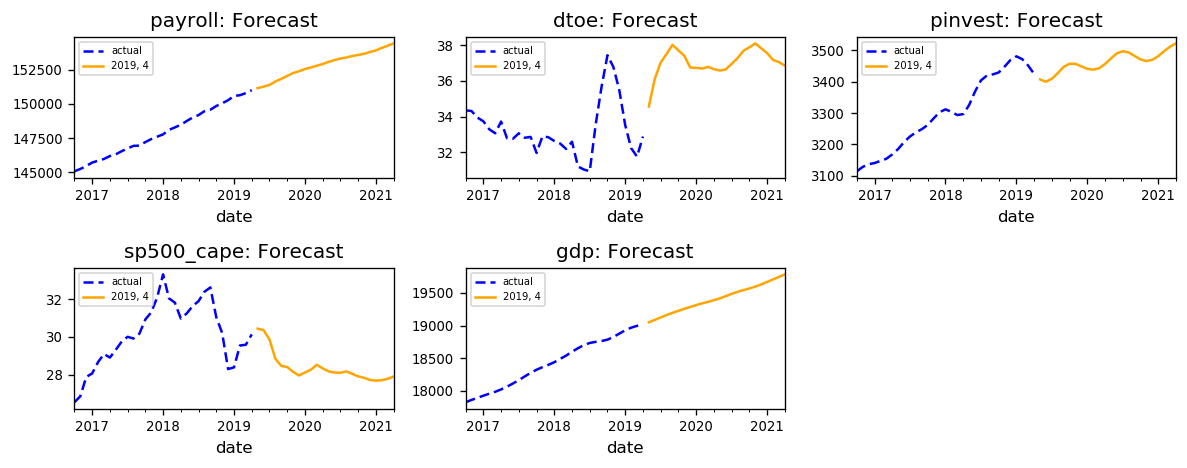

In [47]:
_, _, dtoe_forecast = var_combined_processing(data, 12, '2019, 4', lag_order_var=None)
dtoe_forecast = pd.DataFrame(dtoe_forecast['dtoe'])
dtoe = dtoe.append(dtoe_forecast)
dtoe = dtoe.reset_index().rename(columns={'index':'date'})

data = [tbill_3m, tbill_10y, cpiu, payroll, dtoe, pinvest, sp500_cape, gdp]
data = reduce(lambda left,right: pd.merge(left,right,on='date'), data)
data = data.set_index('date')

data['tbill_10y'] = data['tbill_10y'] - data['tbill_3m']
data = data.drop('tbill_3m', axis=1).rename(columns={'tbill_10y':'tbill'})

data = data.drop(['tbill', 'cpiu'], axis=1)
data_cube_root = data ** (1/3)
data_trans = data_cube_root.diff(1).dropna()

train, test = data[0:-test_periods], data[-test_periods:]
train_trans = data_trans[0:-test_periods]

lag_order = set_coint_lag_order(train_trans, det_order=-1, max_lag=36, significance=0.05)
print('lag order:', lag_order)

var_combined(data, test_periods=24, start_date_1='2019, 8')

### Backtesting

To evaluate whether this model can predict economic trajectory when it really matters, testing against previous recessions is necessary. In these tests, the "test_periods" is changed based on how long the recession lasts. 

#### 1973 Recession

NBER classified 1973 recession from 1973/11 to 1975/3. This recession was caused by the Nixon Shock and oil supply shock, in contrast to to a typical recession, which are caused by overextension of credit.

C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueW

lag order: 10


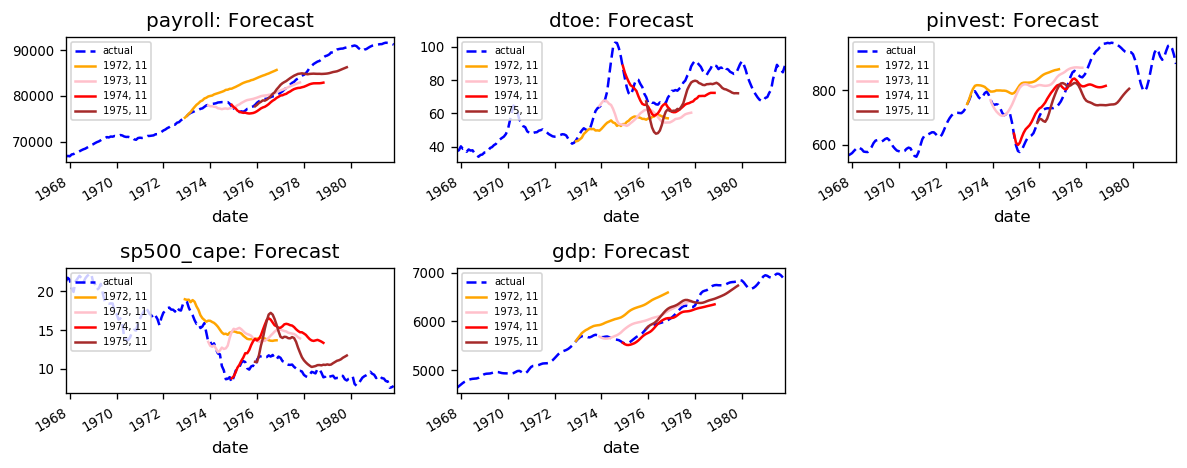

In [48]:
var_combined(data, test_periods=48, start_date_1='1972, 11', start_date_2='1973, 11',
             start_date_3='1974, 11', start_date_4='1975, 11')

#### 2001 Recession

NBER classified 2001 recession from 2001/3 to 2001/11. This recession was relatively mild, with disagreements among economists whether this period should be classified as a recession.

C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueW

lag order: 18


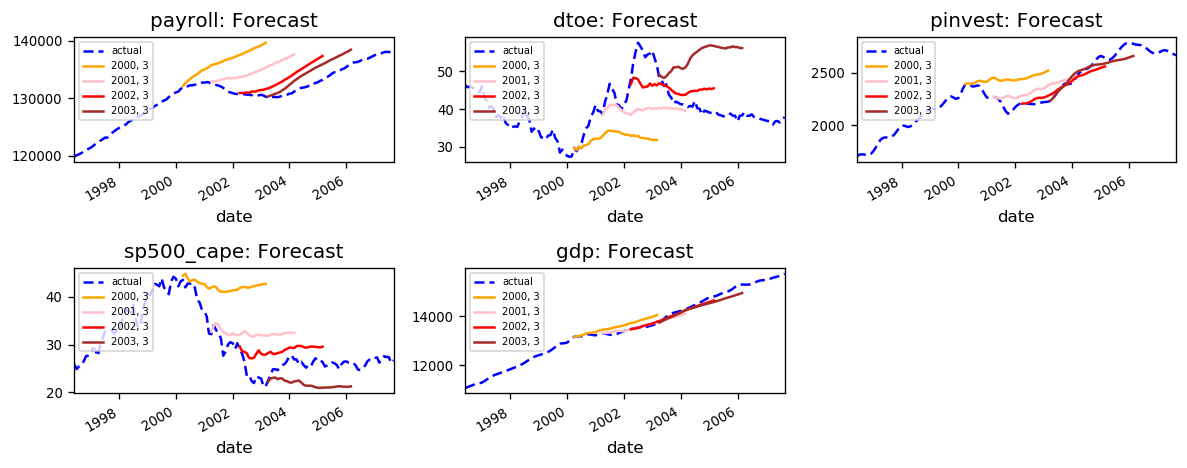

In [49]:
var_combined(data, test_periods=36, start_date_1='2000, 3', start_date_2='2001, 3',
             start_date_3='2002, 3', start_date_4='2003, 3')

#### 2008 Recession

NBER classified 2008 recession from 2007/12 to 2009/6.

C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueW

lag order: 18


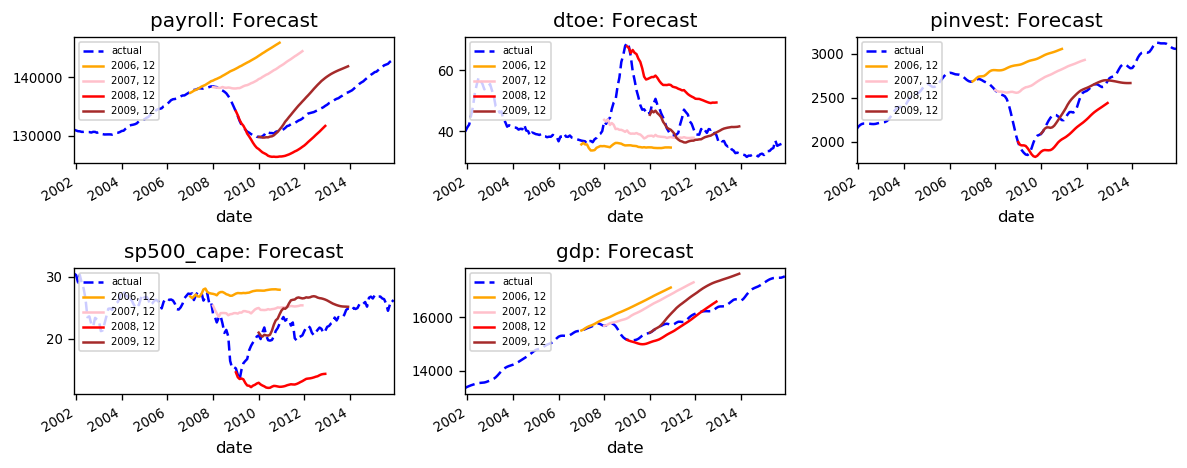

In [50]:
var_combined(data, test_periods=48, start_date_1='2006, 12', start_date_2='2007, 12',
             start_date_3='2008, 12', start_date_4='2009, 12')

#### Economic Expansion

C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueW

lag order: 18


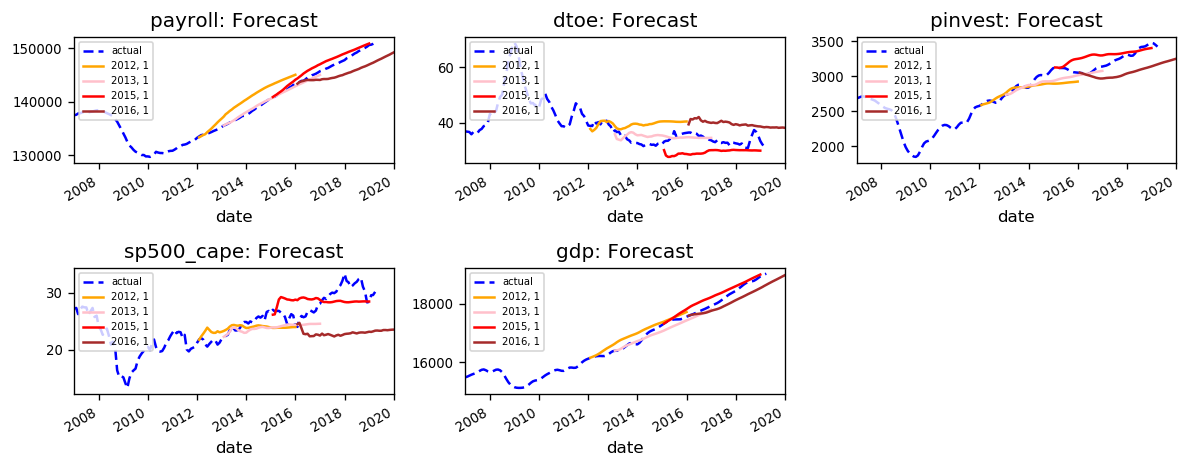

In [51]:
var_combined(data, test_periods=48, start_date_1='2012, 1', start_date_2='2013, 1',
             start_date_3='2015, 1', start_date_4='2016, 1')

#### Long Term Backtesting

C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jyuan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueW

lag order: 20


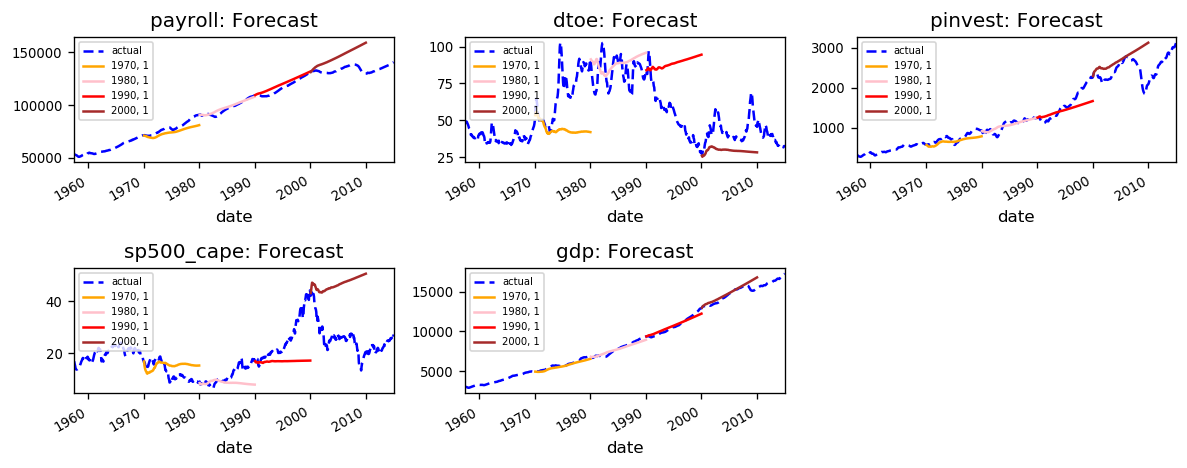

In [52]:
var_combined(data, test_periods=120, start_date_1='1970, 1', start_date_2='1980, 1',
             start_date_3='1990, 1', start_date_4='2000, 1')

### Observations

For the short term, this mode is ineffective at predicting the start of a recession, but does a better job at charting the recovery from a recession. For the long term, this model should not be used.

The model generally inherits the characteristics of the data designated by lag order, stable input begets stable output, while volatile input begets volatile output. However, since the data fed into the model is stationary and stochastic, any shocks to the system converges to the mean overtime, which is why the forecast eventually becomes a straight line when testing for large test period.

### Limitations and Potential Improvements

#### Feature Selection

This predictor does not pinpoint the cause of a recession, but makes a general comment about the state of the economy. The underlying assumption is that these inputs are efficient enough to reflect long term market conditions, but inefficient enough to price in the short term fluctuations in the variables.

#### Data Tranformation

VAR requires data to be stationary and cointegration, but [not all transformation methods are created equal](http://fmwww.bc.edu/repec/bocode/t/transint.html). The method chosen have a direct impact on the result. Also, whether it is appropriate to apply different transformation method to different variables is still debated among the data science community, especially when the data is transformed for the sake of conformance to a model's needs.

#### VAR Model

VAR assumes all variables are endogenous, meaning the values of the variables are determined only by other variables included; while exogenous, or outside, forces are held constant. In reality, GDP is rarely determined by only 5 factors, nor is exogenous forces constant. Examples of exogenous forces include changes rise in oil prices, or changes in taxation policy. VAR may not accurately capture exogenous forces in the model.

To test exogenous effects, Impulse Response Fucntion (IRF) and Forecast Error Variance Decomposition (FEVD) methods can be used to evaluate impact of exogenous shocks. IRF predicts the changes in a variable in reaction to a shock in one or more variables. FEVD gauges the proportion of forecast error variation of the dependent variable explained by other variables. Each variable is passed as dependent variable in VAR. These methods helps to trace the transmission of a single shock within a noisy model.

The impact of exogenous shocks are introduced as a change in an endogenous variable. While these shocks may be modeled in a lower level model, a web of models sprawls from the desire to accurately refine the original model, and the cost scales exponentially.

### Conclusion

Accurate economic modeling is notoriously difficult. The problems begin at definition (what is GDP? what are the units?), then measurement (how to measure GDP?), and each of these questions require teams of the world's leading economists to answer (and they often disagree).

What is reasonable within this particular model, is by using machine learning to quickly test feature selection and transformation processes.

## Part 2

### Data Preparation

#### Setting Up Decision Variable

Let's set up recession decision variable. Difficulty joining series, so had to convert to list, append, then reconvert to series.

In [55]:
# possible to create lambda variables?
r_1953 = pd.Series(pd.date_range(pd.to_datetime('1953, 3, 1'), pd.to_datetime('1954, 5, 1'))).tolist()
r_1957 = pd.Series(pd.date_range(pd.to_datetime('1957, 8, 1'), pd.to_datetime('1958, 4, 1'))).tolist()
r_1960 = pd.Series(pd.date_range(pd.to_datetime('1960, 4, 1'), pd.to_datetime('1961, 2, 1'))).tolist()
r_1962 = pd.Series(pd.date_range(pd.to_datetime('1969, 12, 1'), pd.to_datetime('1970, 11, 1'))).tolist()
r_1973 = pd.Series(pd.date_range(pd.to_datetime('1973, 11, 1'), pd.to_datetime('1975, 3, 1'))).tolist()
r_1980 = pd.Series(pd.date_range(pd.to_datetime('1980, 1, 1'), pd.to_datetime('1980, 7, 1'))).tolist()
r_1981 = pd.Series(pd.date_range(pd.to_datetime('1981, 7, 1'), pd.to_datetime('1982, 11, 1'))).tolist()
r_1990 = pd.Series(pd.date_range(pd.to_datetime('1990, 7, 1'), pd.to_datetime('1991, 3, 1'))).tolist()
r_2001 = pd.Series(pd.date_range(pd.to_datetime('2001, 3, 1'), pd.to_datetime('2001, 11, 1'))).tolist()
r_2007 = pd.Series(pd.date_range(pd.to_datetime('2007, 12, 1'), pd.to_datetime('2009, 6, 1'))).tolist()

print('Original series length:', len(r_1953))

recession_months = pd.Series(r_1953 + r_1957 + r_1960 + r_1962 + r_1973 + r_1980 + r_1981 + r_1990 + r_2001 + r_2007)

# Create a DataFrame for recession
start_date = pd.to_datetime('1953, 4')
end_date = pd.to_datetime('today')
recessions = pd.date_range(start_date, end_date, freq='MS')
recessions = recessions.to_frame().reset_index()

# Mark recession months as 1, non-recession months as 0
recessions.iloc[:,1] = 0
recessions.loc[recessions.iloc[:,0].isin(recession_months), 0] = 1
recessions.rename(columns={'index':'date', 0:'recession'}, inplace=True)


print('Verify series was appended:', len(recession_months))

recessions.iloc[15:20]

Original series length: 427
Verify series was appended: 3511


,date,recession
15,1954-07-01,0
16,1954-08-01,0
17,1954-09-01,0
18,1954-10-01,0
19,1954-11-01,0
